In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,mean_squared_error,confusion_matrix,roc_curve,classification_report,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.feature_selection import RFECV, RFE,SelectFromModel
from sklearn.svm import SVC

In [3]:
data=pd.read_csv(r"C:\Users\User\Desktop\DS-Intern-Assignment-Sehan-Yasaru-Rathnasooriya\data\data.csv")

In [4]:
data.head()

timestamp equipment_energy_consumption lighting_energy  \
0  1/11/2016 17:00                           60    -77.78778597   
1  1/11/2016 17:10                           60              30   
2  1/11/2016 17:20                           50              30   
3  1/11/2016 17:30                           50              40   
4  1/11/2016 17:40                           60              40   

  zone1_temperature zone1_humidity zone2_temperature  zone2_humidity  \
0       33.74660934    47.59666667              19.2       44.790000   
1             19.89    46.69333333              19.2       44.722500   
2             19.89           46.3              19.2       44.626667   
3       33.74660934    46.06666667              19.2       44.590000   
4             19.89    46.33333333              19.2       44.530000   

   zone3_temperature  zone3_humidity  zone4_temperature  ...  \
0              19.79             NaN          19.000000  ...   
1              19.79       44.790000          19.000000  ...   
2              19.79       44.933333          35.921144  ...   
3              19.79       45.000000                NaN  ...   
4              19.79       45.000000          18.890000  ...   

   zone9_temperature  zone9_humidity  outdoor_temperature  \
0          17.033333           45.53             6.600000   
1          17.066667           45.56             6.483333   
2          17.000000           45.50             6.366667   
3          17.000000           45.40             6.250000   
4           4.476511           45.40             6.133333   

   atmospheric_pressure  outdoor_humidity  wind_speed  visibility_index  \
0                 733.5              92.0    7.000000         63.000000   
1                 733.6              92.0    6.666667         59.166667   
2                 733.7              92.0    6.333333         55.333333   
3                 733.8              92.0    6.000000         51.500000   
4                 733.9              92.0    5.666667         47.666667   

   dew_point  random_variable1  random_variable2  
0   5.300000         13.275433         13.275433  
1   5.200000         18.606195         18.606195  
2   5.100000         28.642668         28.642668  
3  37.673716         45.410390         45.410390  
4   4.900000         10.084097         10.084097  

[5 rows x 29 columns]

In [5]:
data.shape

(16857, 29)

In [6]:
data.isnull().sum()

timestamp                         0
equipment_energy_consumption    844
lighting_energy                 809
zone1_temperature               867
zone1_humidity                  801
zone2_temperature               853
zone2_humidity                  867
zone3_temperature               802
zone3_humidity                  878
zone4_temperature               816
zone4_humidity                  781
zone5_temperature               838
zone5_humidity                  801
zone6_temperature               848
zone6_humidity                  847
zone7_temperature               794
zone7_humidity                  805
zone8_temperature               848
zone8_humidity                  777
zone9_temperature               773
zone9_humidity                  888
outdoor_temperature             806
atmospheric_pressure            842
outdoor_humidity                799
wind_speed                      828
visibility_index                815
dew_point                       826
random_variable1            

In [7]:
data.duplicated().sum()

68

In [8]:
data=data.drop_duplicates()

In [9]:
data.duplicated().sum()

0

In [10]:
data.shape

(16789, 29)

In [11]:
temp_columns=["zone1_temperature","zone2_temperature","zone3_temperature","zone4_temperature","zone5_temperature","zone6_temperature","zone7_temperature","zone8_temperature","zone9_temperature","outdoor_temperature"]
humidity_columns=["zone1_humidity","zone2_humidity","zone3_humidity","zone4_humidity","zone5_humidity","zone6_humidity","zone7_humidity","zone8_humidity","zone9_humidity","outdoor_humidity"]
other_params=["atmospheric_pressure","visibility_index","wind_speed"]

data["timestamp"]=pd.to_datetime(data["timestamp"],errors='coerce')
data=data.sort_values("timestamp")

environment_effects=temp_columns+humidity_columns

for col in humidity_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce').abs()

for col in other_params:
    data[col] = pd.to_numeric(data[col], errors='coerce').abs()
    
for col in environment_effects:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
for col in other_params:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
for col in temp_columns:
    
    rate_of_change = data[col].diff().abs() / (data['timestamp'].diff().dt.total_seconds() / 60)
    negative_mask = data[col] < 0
    data.loc[negative_mask &(rate_of_change > 0.5), col] = np.nan

for col in other_params:
    rate_of_change_of_others = data[col].diff().abs() / (data['timestamp'].diff().dt.total_seconds() / 60)
    data.loc[rate_of_change_of_others > 0.5, col] = np.nan
    
data[environment_effects] = data[environment_effects].interpolate(method='linear', limit_direction='both')
data[environment_effects] = data[environment_effects].fillna(method='ffill').fillna(method='bfill')

data[other_params] = data[other_params].interpolate(method='linear', limit_direction='both')
data[other_params] = data[other_params].fillna(method='ffill').fillna(method='bfill')



C:\Users\User\AppData\Local\Temp\ipykernel_7260\261648497.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[environment_effects] = data[environment_effects].fillna(method='ffill').fillna(method='bfill')
C:\Users\User\AppData\Local\Temp\ipykernel_7260\261648497.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[other_params] = data[other_params].fillna(method='ffill').fillna(method='bfill')


In [224]:
data['lighting_energy'] = pd.to_numeric(data['lighting_energy'], errors='coerce')
mask = data['lighting_energy'] < 0
data.loc[mask, 'lighting_energy'] = data['lighting_energy'].shift(-1)

data['lighting_energy'] = data['lighting_energy'].interpolate(method='linear', limit_direction='both')
data['lighting_energy'] = data['lighting_energy'].fillna(method='ffill').fillna(method='bfill')

data['dew_point'] = data['dew_point'].interpolate(method='linear', limit_direction='both')
data['dew_point'] = data['dew_point'].fillna(method='ffill').fillna(method='bfill')



C:\Users\User\AppData\Local\Temp\ipykernel_2696\868290357.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['lighting_energy'] = data['lighting_energy'].fillna(method='ffill').fillna(method='bfill')
C:\Users\User\AppData\Local\Temp\ipykernel_2696\868290357.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['dew_point'] = data['dew_point'].fillna(method='ffill').fillna(method='bfill')


In [225]:
data['dew_point'] = pd.to_numeric(data['dew_point'], errors='coerce')
change_dew = data['dew_point'].diff().abs() / (data['timestamp'].diff().dt.total_seconds() / 60)
data.loc[change_dew > 0.5,'dew_point'] = np.nan

data['dew_point']  =data['dew_point'] .interpolate(method='linear', limit_direction='both')
data['dew_point']  = data['dew_point'] .fillna(method='ffill').fillna(method='bfill')


C:\Users\User\AppData\Local\Temp\ipykernel_2696\3728490798.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['dew_point']  = data['dew_point'] .fillna(method='ffill').fillna(method='bfill')


In [226]:
for col in temp_columns+humidity_columns:
    data[col]=pd.to_numeric(data[col],errors='coerce')
for temp_col,hum_col in zip(temp_columns,humidity_columns):
    THI_col=temp_col.replace("temperature","THI")
    data[THI_col]=data[temp_col]-(0.55-0.0055*data[hum_col])*(data[temp_col]-14.5)


In [227]:
cols_to_drop=temp_columns+humidity_columns
data.drop(columns=cols_to_drop,inplace=True)


In [228]:
data['equipment_energy_consumption']  =data['equipment_energy_consumption'] .interpolate(method='linear', limit_direction='both')
data['equipment_energy_consumption']  = data['equipment_energy_consumption'] .fillna(method='ffill').fillna(method='bfill')

C:\Users\User\AppData\Local\Temp\ipykernel_2696\504465497.py:1: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data['equipment_energy_consumption']  =data['equipment_energy_consumption'] .interpolate(method='linear', limit_direction='both')
C:\Users\User\AppData\Local\Temp\ipykernel_2696\504465497.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['equipment_energy_consumption']  = data['equipment_energy_consumption'] .fillna(method='ffill').fillna(method='bfill')


In [229]:
data.shape

(16789, 19)

In [230]:
data.isnull().sum()

timestamp                         0
equipment_energy_consumption      0
lighting_energy                   0
atmospheric_pressure              0
wind_speed                        0
visibility_index                  0
dew_point                         0
random_variable1                824
random_variable2                823
zone1_THI                         0
zone2_THI                         0
zone3_THI                         0
zone4_THI                         0
zone5_THI                         0
zone6_THI                         0
zone7_THI                         0
zone8_THI                         0
zone9_THI                         0
outdoor_THI                       0
dtype: int64

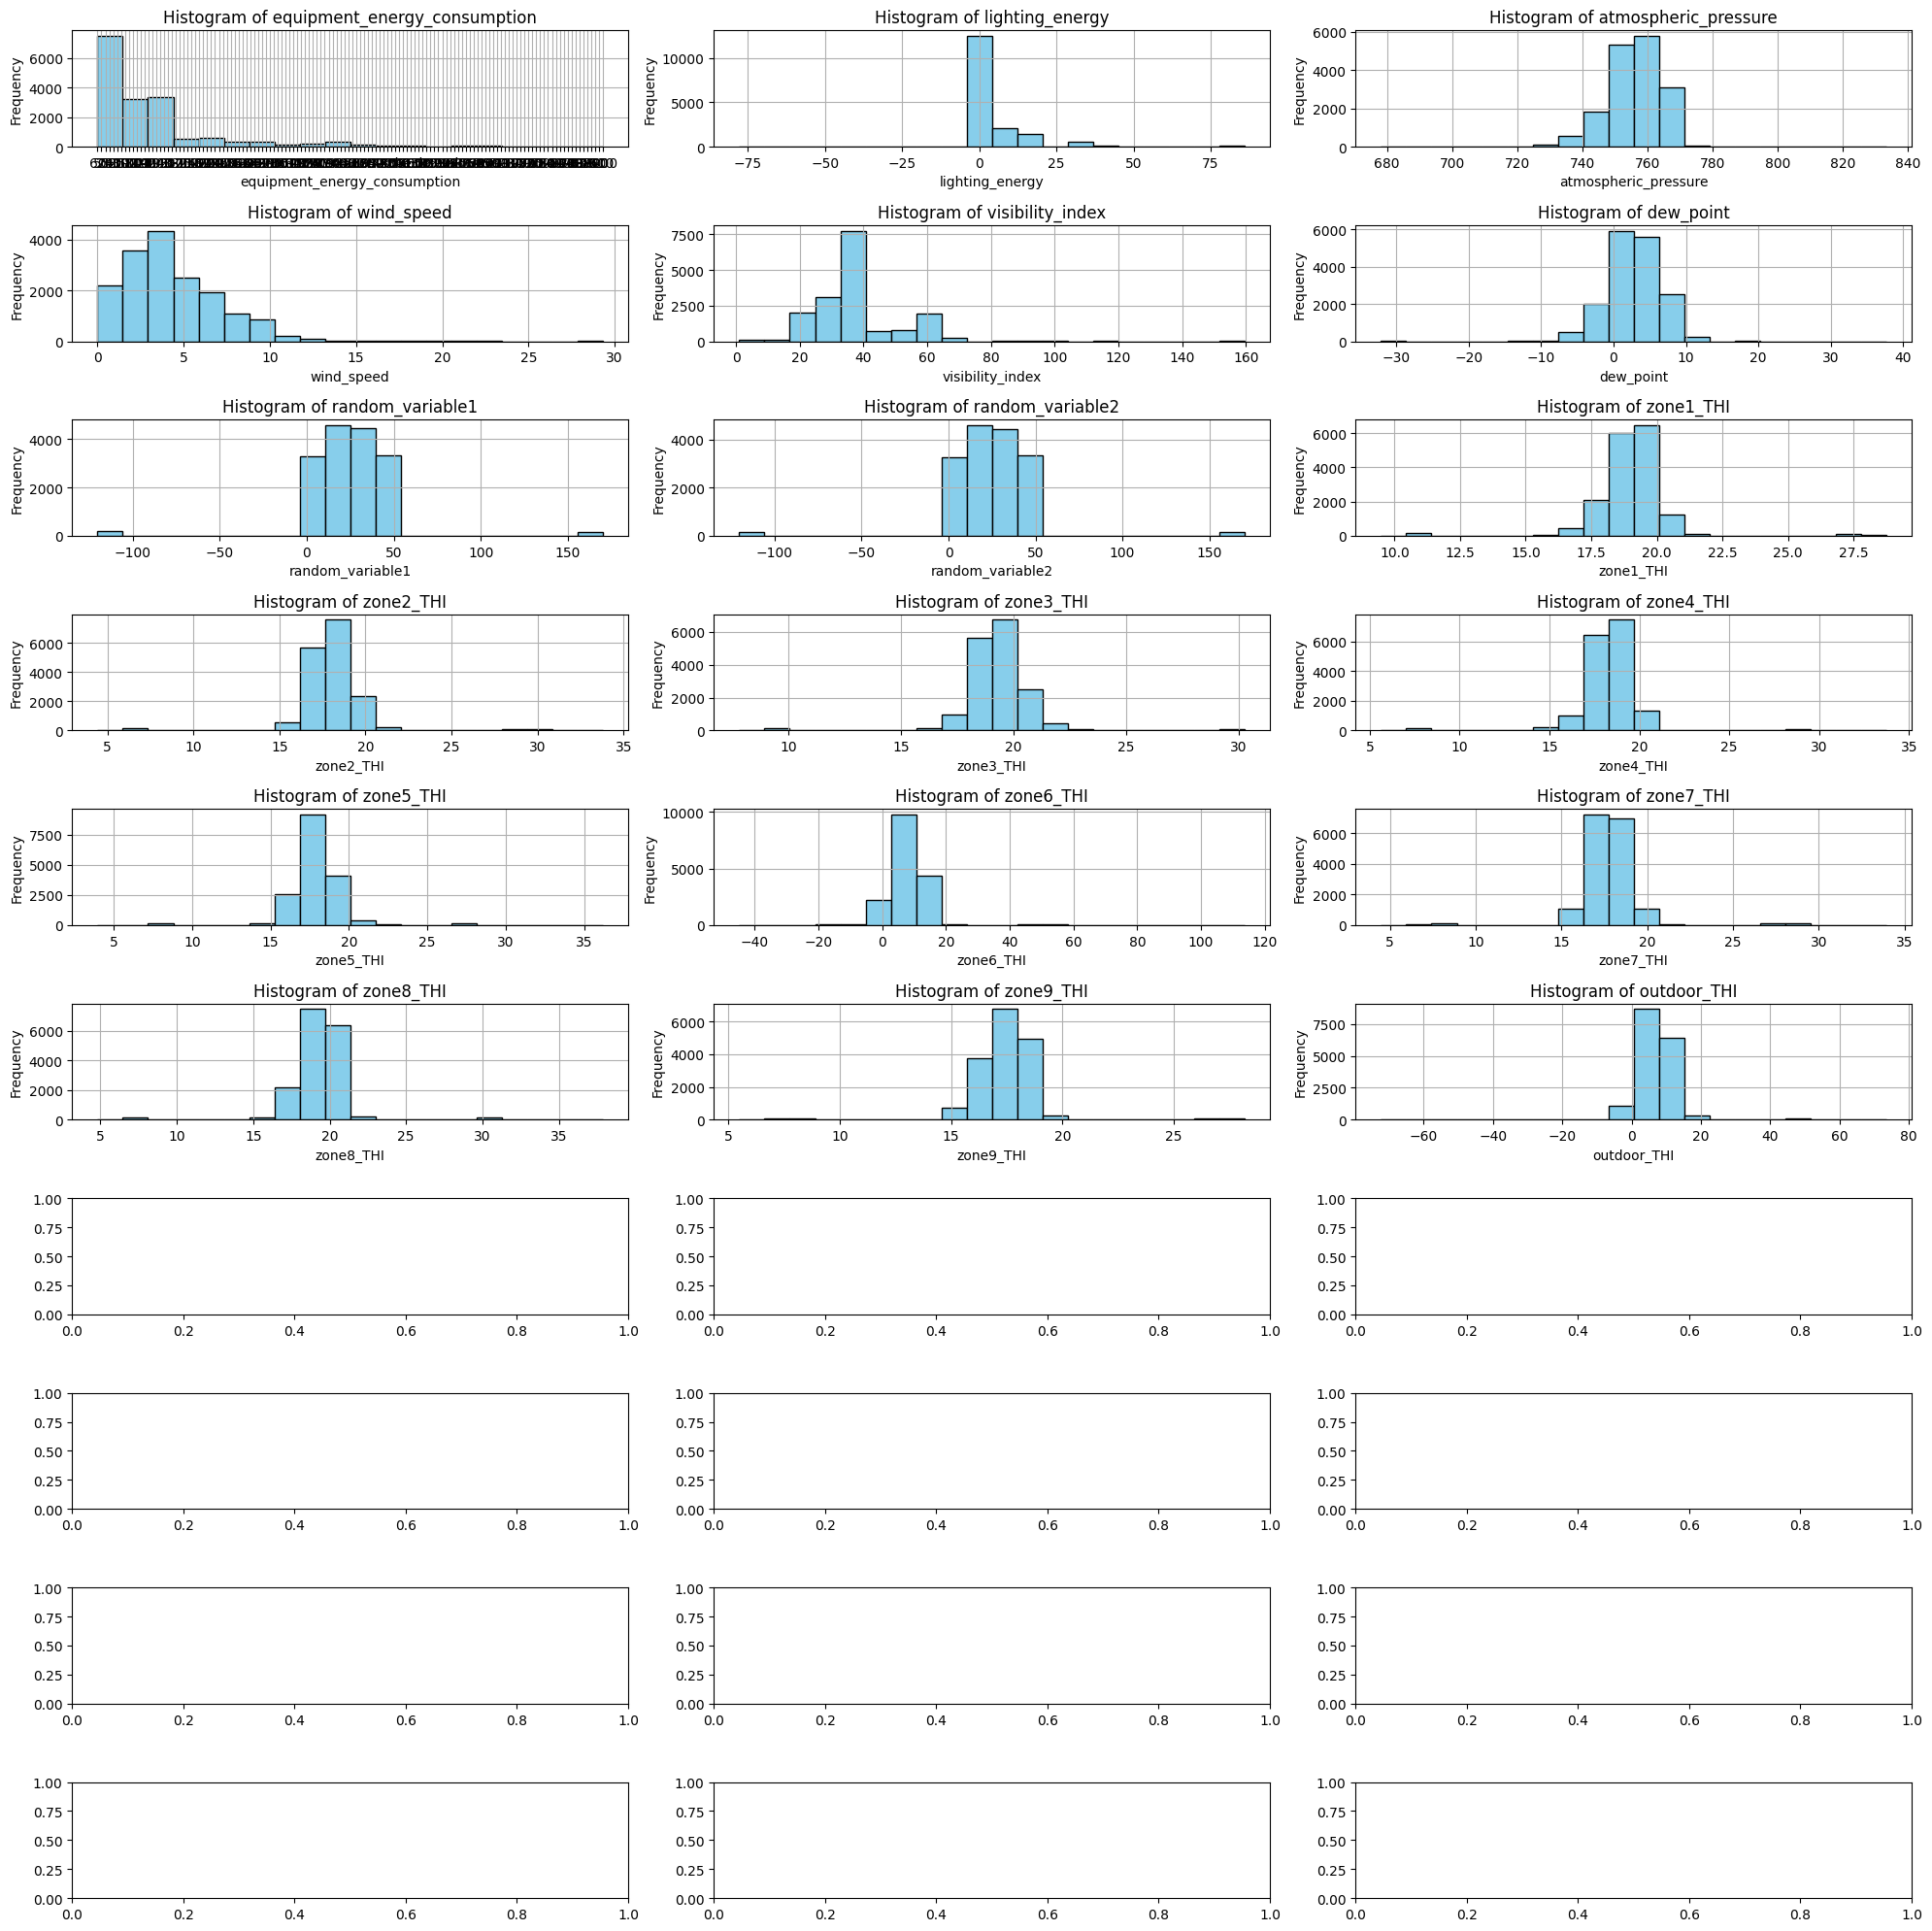

In [231]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(20, 20))
axes = axes.flatten()
Display_data=data.iloc[:,1:]
for i, column in enumerate(Display_data):  
    axes[i].hist(Display_data[column], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

plt.tight_layout()

plt.show()

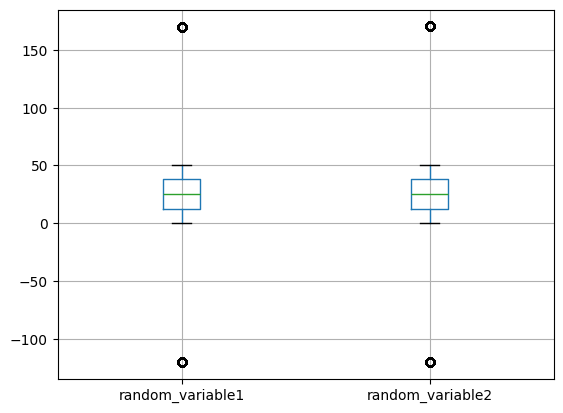

In [232]:
data.boxplot(["random_variable1","random_variable2"])
plt.show()

In [233]:
data=data.drop(columns=["random_variable1","random_variable2"])

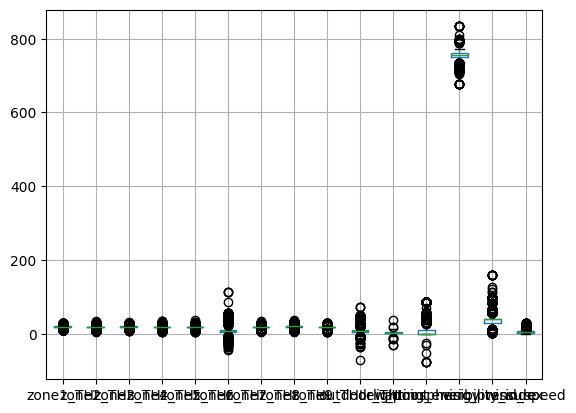

In [193]:
data.boxplot(["zone1_THI","zone2_THI","zone3_THI","zone4_THI","zone5_THI","zone6_THI","zone7_THI","zone8_THI","zone9_THI","outdoor_THI",'dew_point','lighting_energy',"atmospheric_pressure","visibility_index","wind_speed"])
plt.show()

In [196]:

data.duplicated().sum()
data=data.drop_duplicates()

In [234]:
data['equipment_energy_consumption'] = pd.to_numeric(data['equipment_energy_consumption'], errors='coerce')
data = data[
    (data['equipment_energy_consumption'] >=10 ) & 
    (data['equipment_energy_consumption'] <= 1000)
]

In [235]:
data.shape

(16209, 17)

In [1]:
data_num=data[["zone1_THI","zone2_THI","zone3_THI","zone4_THI","zone5_THI","zone6_THI","zone7_THI","zone8_THI","zone9_THI","outdoor_THI",'dew_point','lighting_energy',"atmospheric_pressure","visibility_index","wind_speed"]]
data_num_log = data_num.copy()
for col in data_num.columns:
    if data_num[col].min() > 0: 
        data_num_log[col] = np.log1p(data_num[col])
Q1_log = data_num_log.quantile(0.25)
Q3_log = data_num_log.quantile(0.75)
IQR_log = Q3_log - Q1_log
Outliers_log = ((data_num_log < (Q1_log - 1.5 * IQR_log)) | (data_num_log > (Q3_log + 1.5 * IQR_log))).any(axis=1)
print(f"Rows with outliers after log-transform: {Outliers_log.sum()}")

NameError: name 'data' is not defined

In [208]:
Outliers=((data_num<(Q1-1.5*IQR))|(data_num>(Q3+1.5*IQR))).any(axis=1)
data=data[~Outliers]

In [209]:
data.shape

(9909, 17)

In [210]:
correlations = data.corr()
correlation_with_target = correlations['equipment_energy_consumption'].sort_values(ascending=False)
print(correlation_with_target)

equipment_energy_consumption    1.000000
lighting_energy                 0.191448
zone2_THI                       0.130935
zone3_THI                       0.124082
zone6_THI                       0.111430
outdoor_THI                     0.109160
zone1_THI                       0.097569
wind_speed                      0.064765
zone4_THI                       0.058018
zone8_THI                       0.041041
zone7_THI                       0.021930
visibility_index                0.018888
zone9_THI                       0.012226
zone5_THI                       0.009780
timestamp                      -0.006794
dew_point                      -0.007577
atmospheric_pressure           -0.038094
Name: equipment_energy_consumption, dtype: float64


In [212]:
data=data.reindex(columns=["timestamp","zone1_THI","zone2_THI","zone3_THI","zone4_THI","zone5_THI","zone6_THI","zone7_THI","zone8_THI","zone9_THI","outdoor_THI",'dew_point',"atmospheric_pressure","visibility_index","wind_speed",'lighting_energy',"equipment_energy_consumption"])

In [213]:
data.head()

timestamp  zone1_THI  zone2_THI  zone3_THI  zone4_THI  zone5_THI  \
14 2016-01-11 19:20:00  18.988936  18.260826  18.436395  17.730243  16.463650   
15 2016-01-11 19:30:00  19.028241  18.412961  18.524716  17.725127  16.509319   
16 2016-01-11 19:40:00  19.107895  18.521794  18.586416  17.664454  16.528520   
20 2016-01-11 20:20:00  19.077689  18.498400  18.524183  17.888025  17.654717   
25 2016-01-11 21:10:00  19.202730  18.677080  18.647905  17.986081  17.987372   

    zone6_THI  zone7_THI  zone8_THI  zone9_THI  outdoor_THI  dew_point  \
14   6.460190  16.925834  17.094028  16.171560     6.467500   4.433333   
15   6.356655  16.863158  17.130190  16.171319     6.490875   4.350000   
16   6.297986  16.760701  17.196728  16.170837     6.514250   4.266667   
20   6.102117  16.616783  18.599383  16.169172     6.576583   4.033333   
25   6.357545  16.765823  17.803298  16.165710     6.537997   3.866667   

    atmospheric_pressure  visibility_index  wind_speed  lighting_energy  \
14            734.733333              40.0         6.0             10.0   
15            734.850000              40.0         6.0             10.0   
16            734.966667              40.0         6.0             10.0   
20            735.266667              40.0         6.0             20.0   
25            735.466667              40.0         6.0             20.0   

    equipment_energy_consumption  
14                         100.0  
15                         100.0  
16                          90.0  
20                         120.0  
25                         110.0

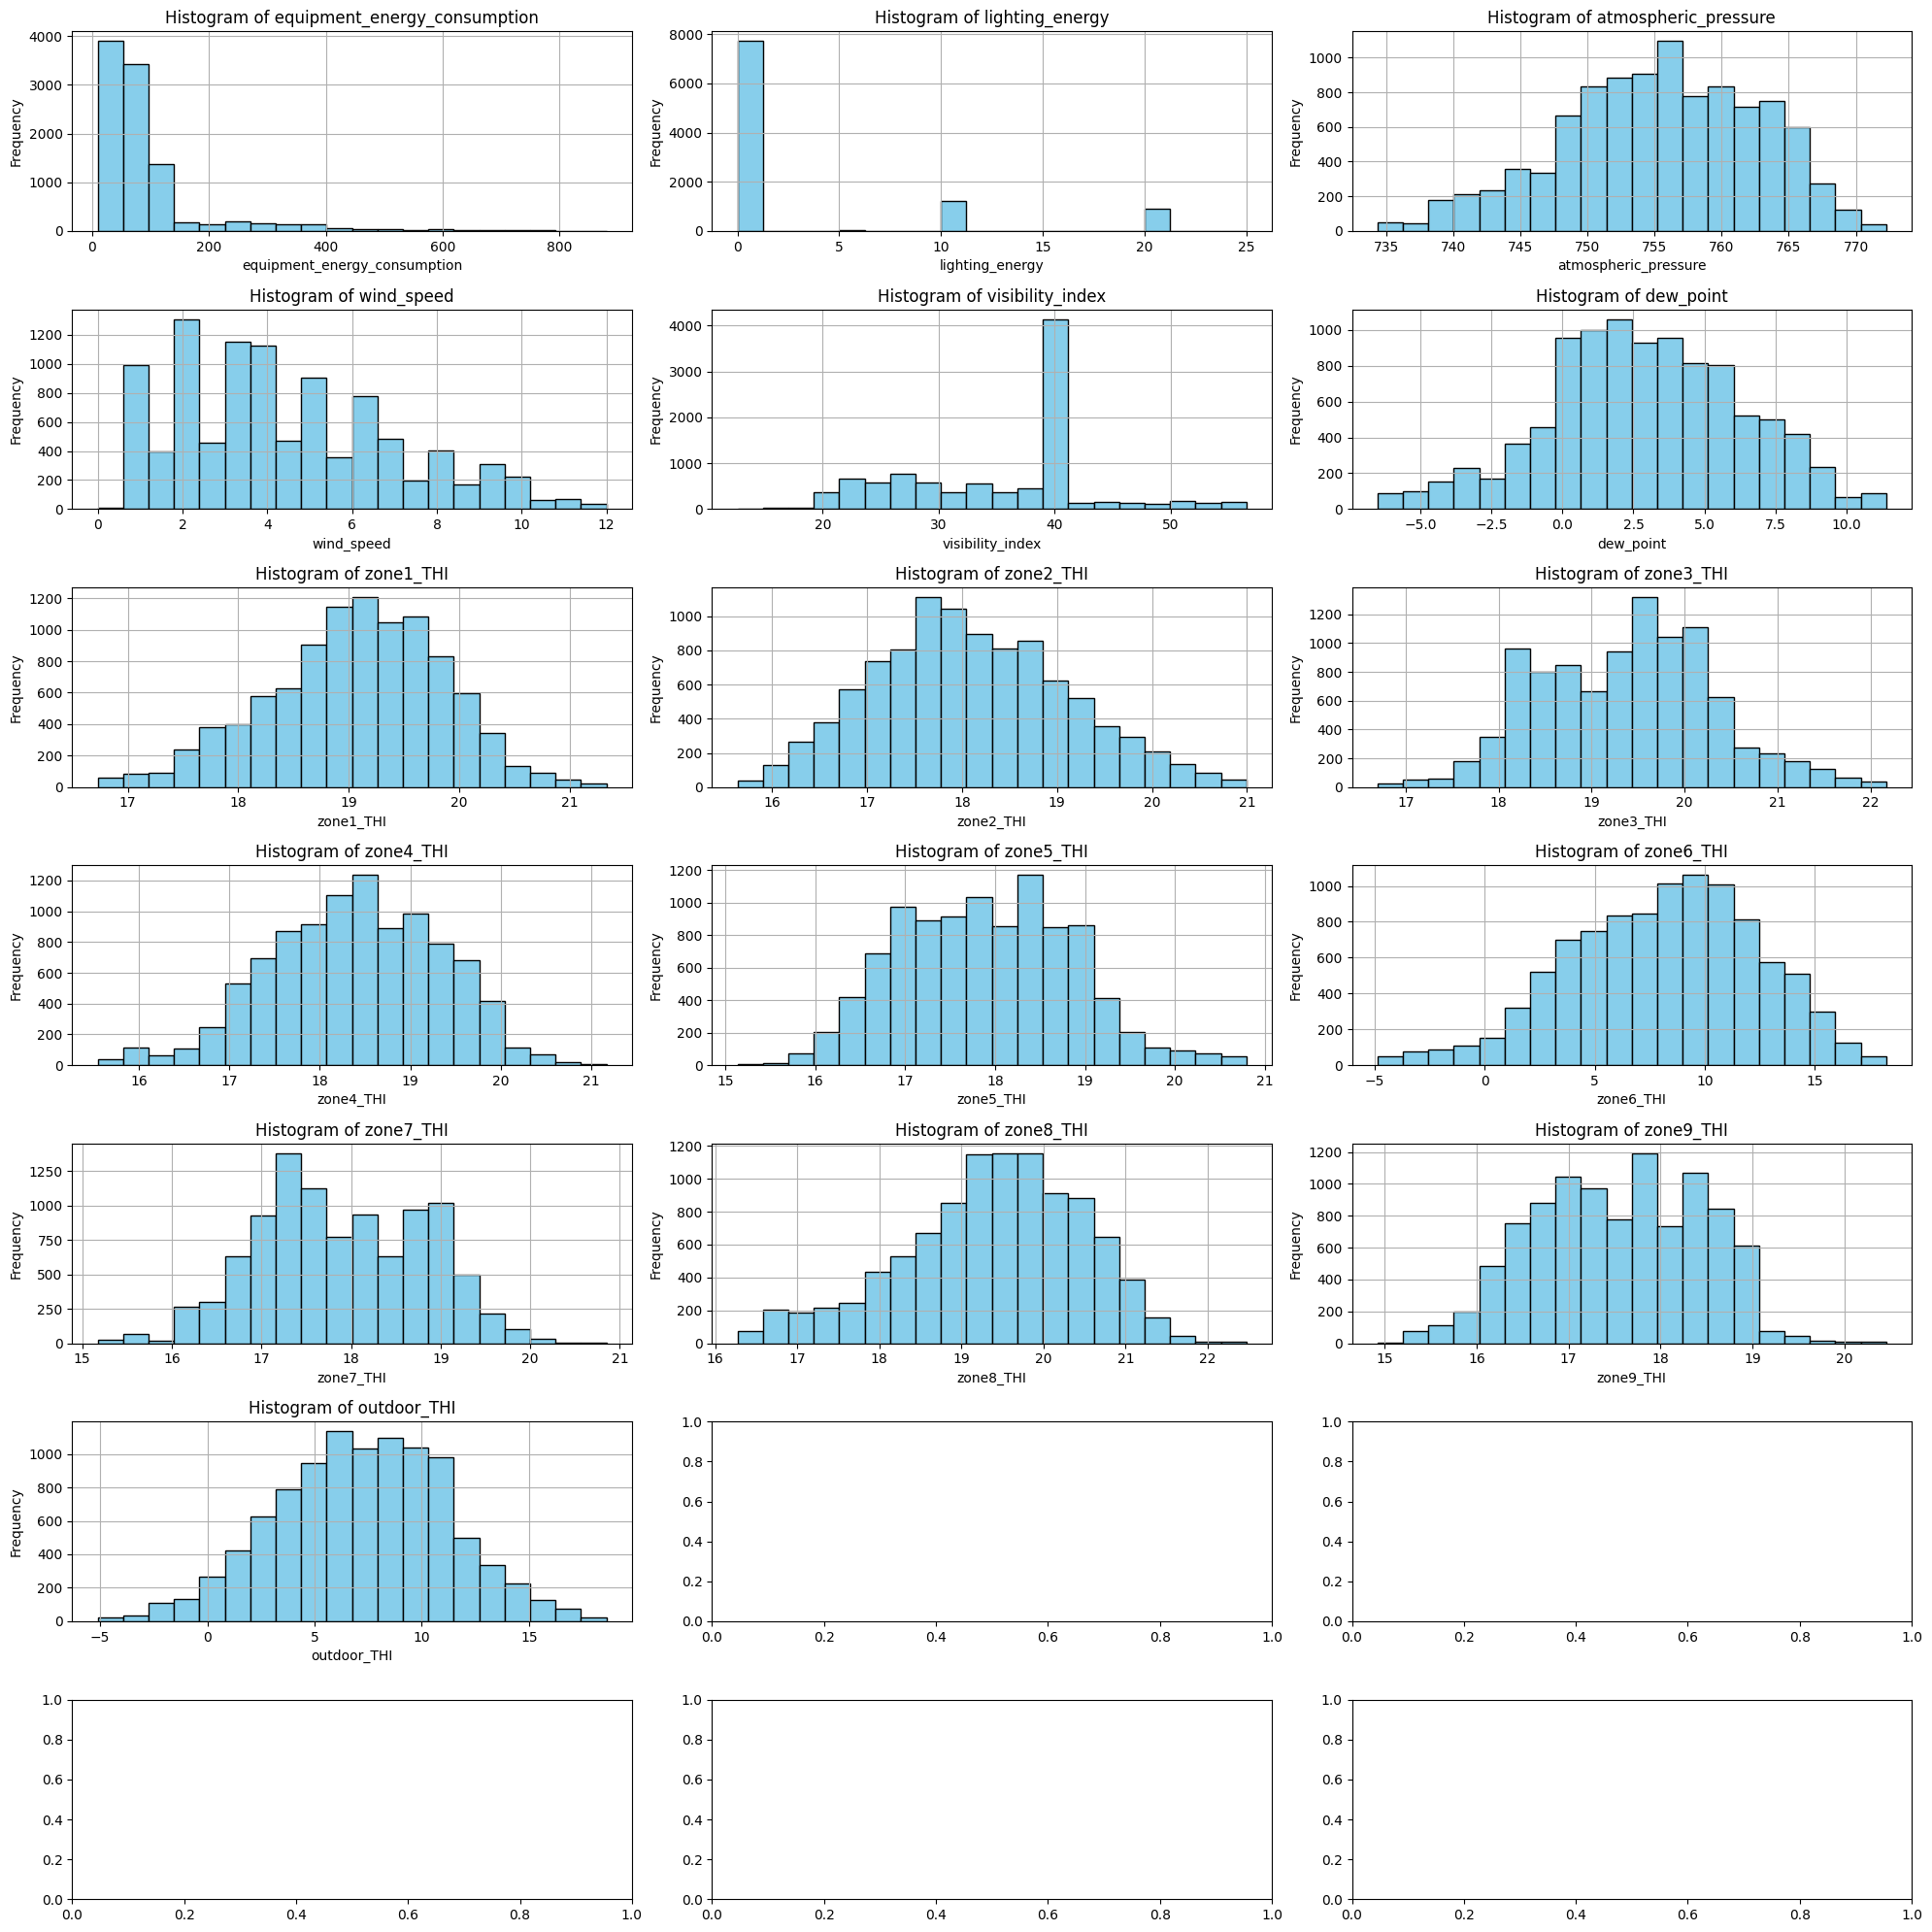

In [144]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(20, 20))
axes = axes.flatten()
display_data=data.iloc[:,1:]
for i, column in enumerate(display_data):  
    axes[i].hist(display_data[column], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)


plt.tight_layout()

plt.show()

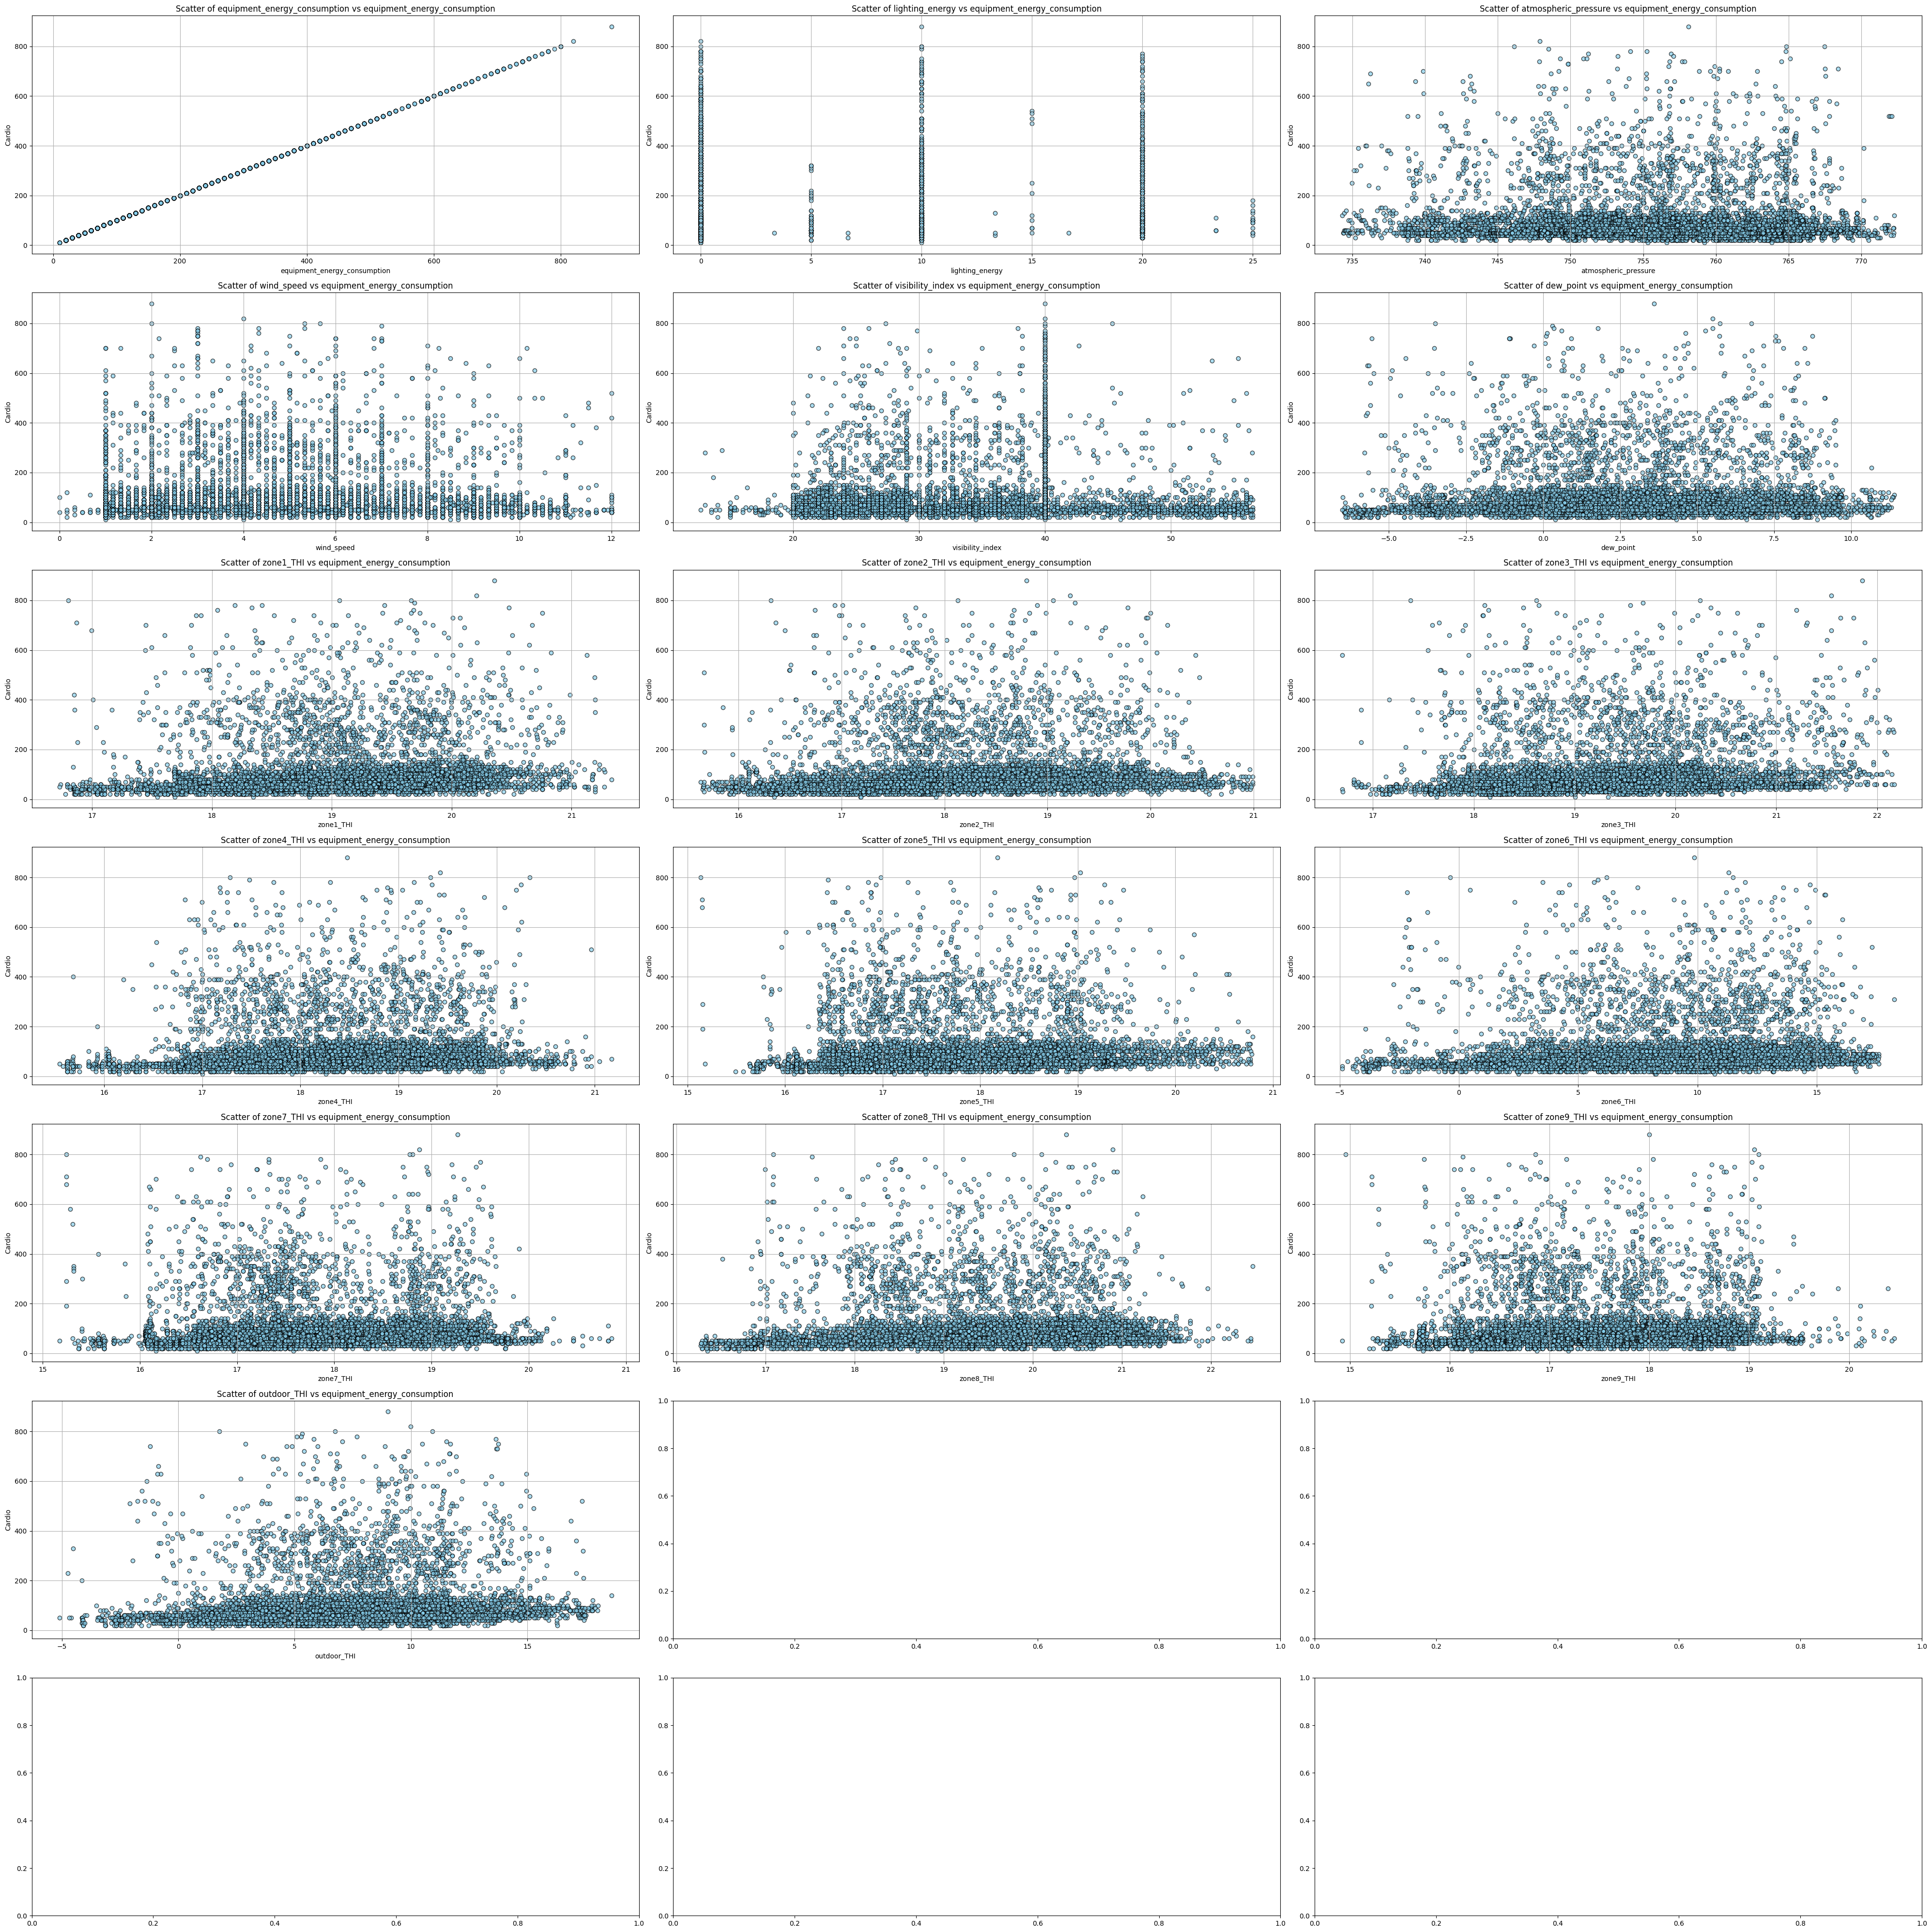

In [211]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(40,40))
axes = axes.flatten()
display_data=data.iloc[:,1:]
for i, column in enumerate(display_data):
    axes[i].scatter(display_data[column], data['equipment_energy_consumption'], color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Scatter of {column} vs equipment_energy_consumption')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Cardio")
    axes[i].grid(True)

plt.tight_layout()

plt.show()

In [214]:
data.to_csv('cleaned_data1.csv', index=False)